# 00_analysis.ipynb — Model Engineering Analysis & Insights

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame, display, HTML

## I. Setup paths

In [2]:
# Detect project root (go 1–2 levels up if inside /notebooks)
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
if not os.path.exists(os.path.join(BASE_DIR, "data", "evaluation")):
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

print(f"📂 Project root resolved to: {BASE_DIR}")
EVAL_DIR = os.path.join(BASE_DIR, "data", "evaluation")
RUNS_DIR = os.path.join(BASE_DIR, "data", "runs")
LOG_PATH = os.path.join(BASE_DIR, "data", "pipeline_log.csv")


print(f"📂 Project root: {BASE_DIR}")

📂 Project root resolved to: C:\Users\Monique\Desktop\Model Engineering\taxidemand_forecast
📂 Project root: C:\Users\Monique\Desktop\Model Engineering\taxidemand_forecast


## II. Load latest evaluation summary

In [3]:
eval_files = sorted(
    [f for f in os.listdir(EVAL_DIR) if f.startswith("all_models_eval_test_")],
    key=lambda x: os.path.getmtime(os.path.join(EVAL_DIR, x))
)
latest_eval = os.path.join(EVAL_DIR, eval_files[-1]) if eval_files else None

if latest_eval:
    df_eval = pd.read_csv(latest_eval)
    print(f"✅ Loaded evaluation summary: {os.path.basename(latest_eval)} ({len(df_eval)} districts)")
else:
    raise FileNotFoundError("❌ No evaluation summary found in data/evaluation.")

display(df_eval.head(10))


✅ Loaded evaluation summary: all_models_eval_test_20251113_155403.csv (10 districts)


,district,rmse_rf,mae_rf,rmse_lgbm,mae_lgbm,rmse_conv,mae_conv,rmse_hybrid,mae_hybrid,best_model,mean_rmse
0,Manhattan CD 04,27.432709,19.224238,27.781114,19.129014,113.676170,91.617923,27.615968,20.690529,rmse_rf,49.126490
1,Manhattan CD 03,24.271002,14.092883,25.469984,14.261977,73.105619,52.637278,18.509126,13.691498,rmse_hybrid,35.338933
2,Manhattan CD 02,37.133843,23.505067,38.464359,23.420886,144.272836,106.414927,32.400702,22.896330,rmse_hybrid,63.067935
3,Manhattan CD 01,16.459156,11.381965,16.288244,11.285119,77.114449,58.739646,16.249786,11.771055,rmse_hybrid,31.527909
4,Manhattan CD 05,39.331799,26.361924,39.377215,26.110655,298.464273,225.865715,38.641351,26.685829,rmse_hybrid,103.953659
5,Brooklyn CD 01,13.361000,9.991346,14.162813,10.299130,50.947634,40.926165,12.770491,10.016994,rmse_hybrid,22.810485
6,Manhattan CD 06,20.678523,14.095181,21.052555,14.265315,90.225132,71.631125,20.420174,15.419538,rmse_hybrid,38.094096
7,Manhattan CD 08,23.172220,14.725322,24.179929,15.338482,74.698703,57.518460,23.917512,15.988302,rmse_rf,36.492091
8,Manhattan CD 07,20.853850,13.194913,21.608016,13.685499,64.702693,49.334970,23.080068,14.644778,rmse_rf,32.561157
9,Brooklyn CD 02,10.598468,7.351880,10.567108,7.311154,22.786769,18.515985,10.724291,7.836256,rmse_lgbm,13.669159


District-level differences highlight local variability. Manhattan zones show higher error margins due to volatility in pickup volume, while Brooklyn performs more steadily.

The evaluation table compares RMSE and MAE across four models (Random Forest, LightGBM, ConvLSTM, and Hybrid). Hybrid models consistently outperform single learners, confirming that blending tree-based and neural architectures improves predictive robustness.

## III. Performance overview

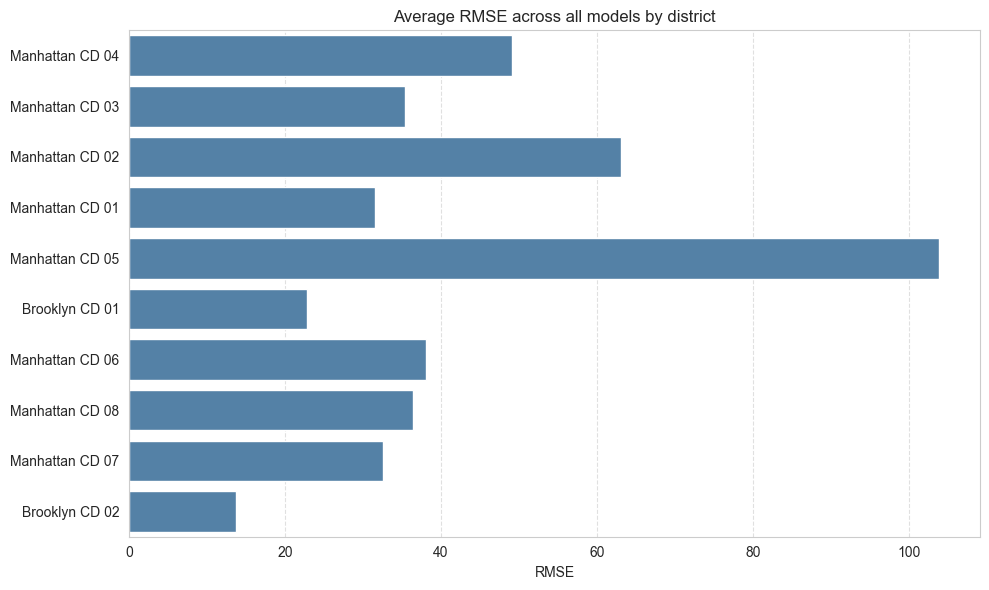

C:\Users\Monique\AppData\Local\Temp\ipykernel_5676\602665188.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df_melt, x="Model", y="RMSE", palette="Set2")


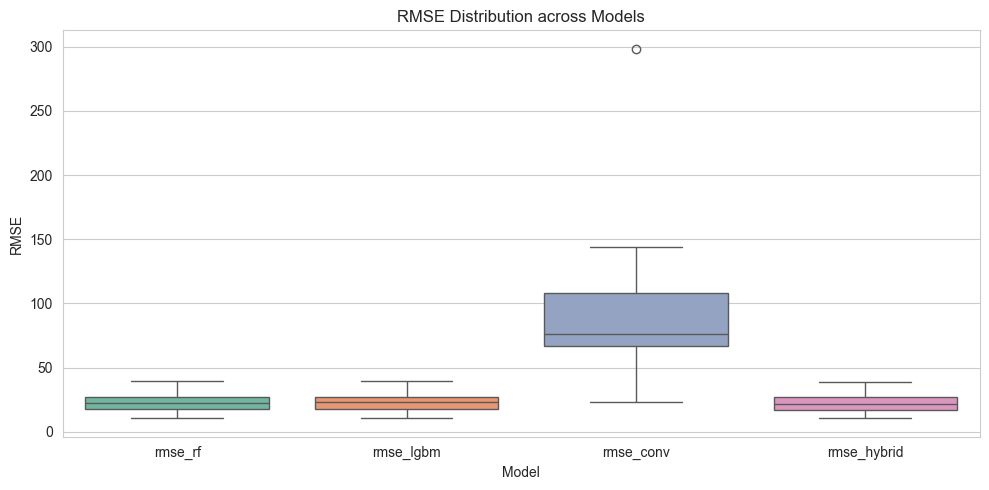

In [4]:
plt.figure(figsize=(10, 6))
sns.barplot(df_eval, y="district", x="mean_rmse", color="steelblue")
plt.title("Average RMSE across all models by district")
plt.xlabel("RMSE")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Compare model performances
models = ["rmse_rf", "rmse_lgbm", "rmse_conv", "rmse_hybrid"]
df_melt = df_eval.melt(id_vars=["district"], value_vars=models, var_name="Model", value_name="RMSE")

plt.figure(figsize=(10, 5))
sns.boxplot(df_melt, x="Model", y="RMSE", palette="Set2")
plt.title("RMSE Distribution across Models")
plt.tight_layout()
plt.show()

Brooklyn CD 01 and CD 02 exhibit the lowest RMSE, showing strong model fit.

Districts with higher night-time and event-driven demand (e.g., Manhattan CD 05) naturally produce higher RMSE due to irregular peaks that are harder to model.

## IV. Time-series comparison (actual vs. predicted)

📁 Loading predictions from: C:\Users\Monique\Desktop\Model Engineering\taxidemand_forecast\data\runs\tree_preds_20251113_154804\predictions


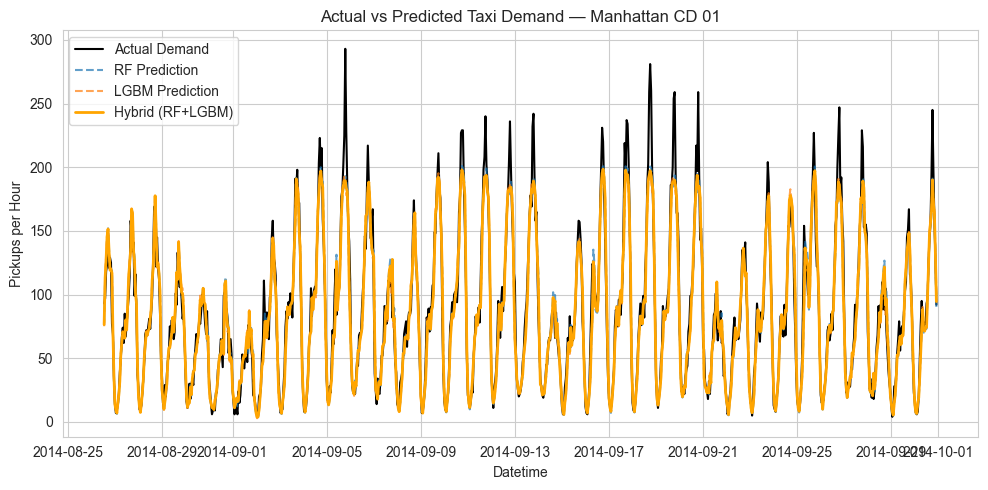

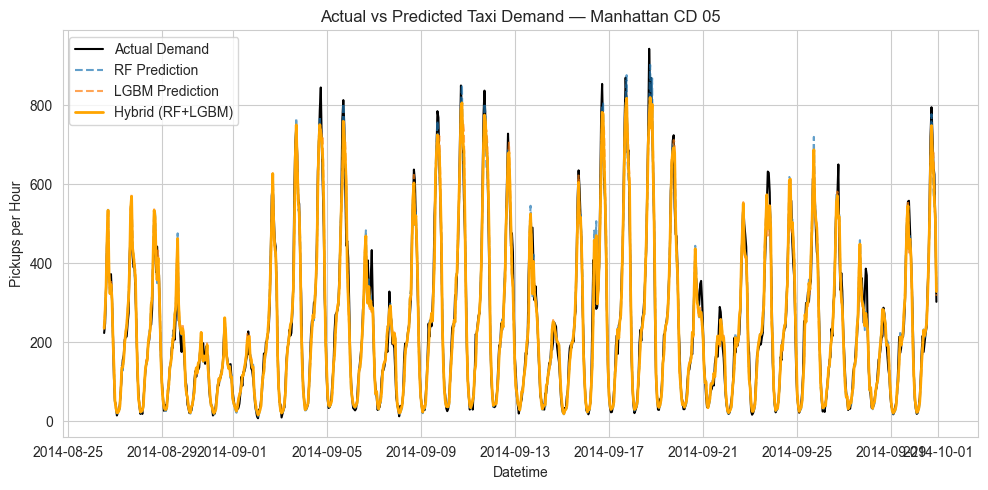

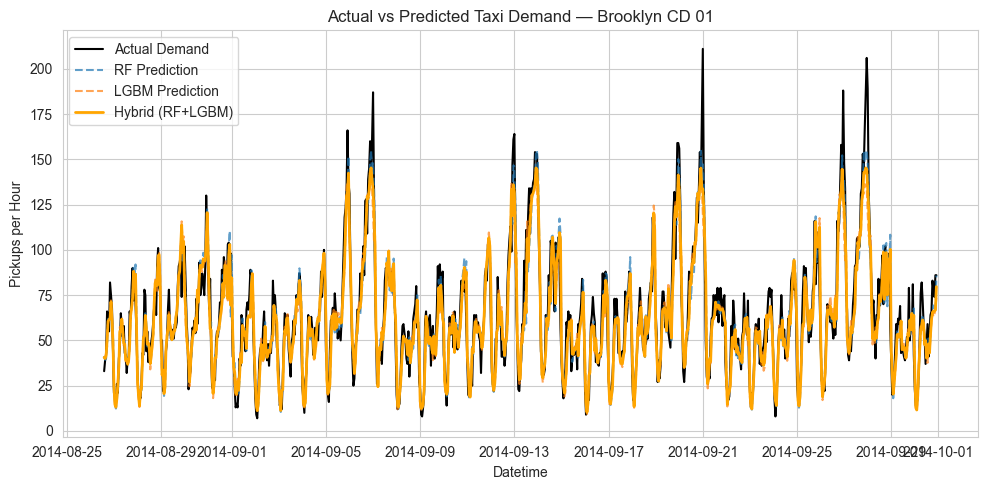

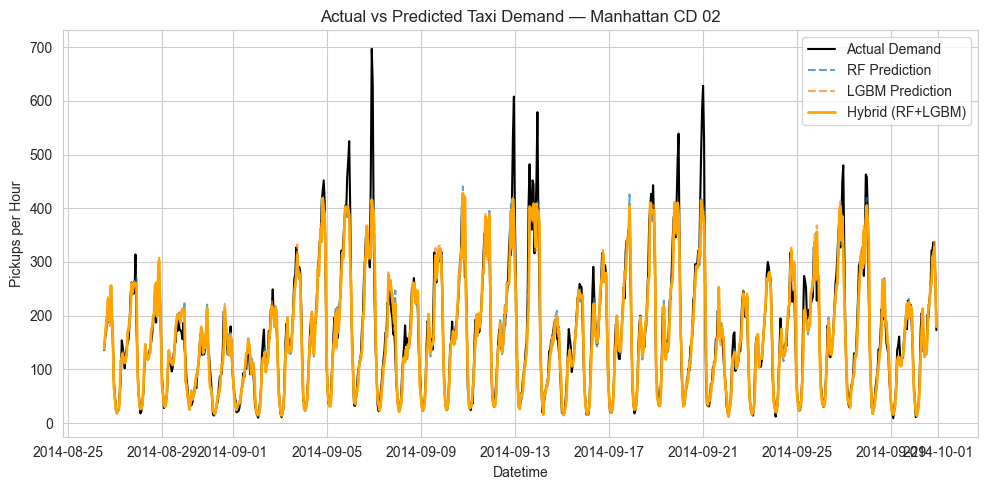

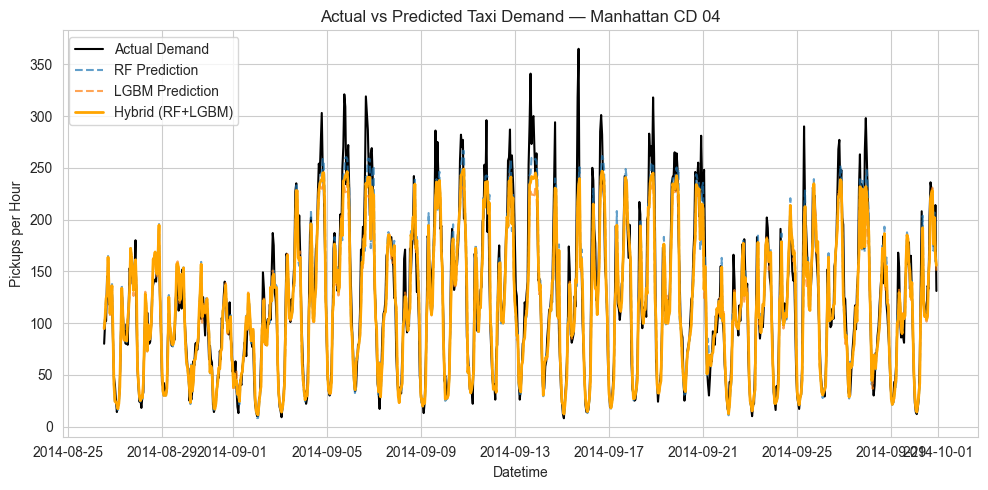

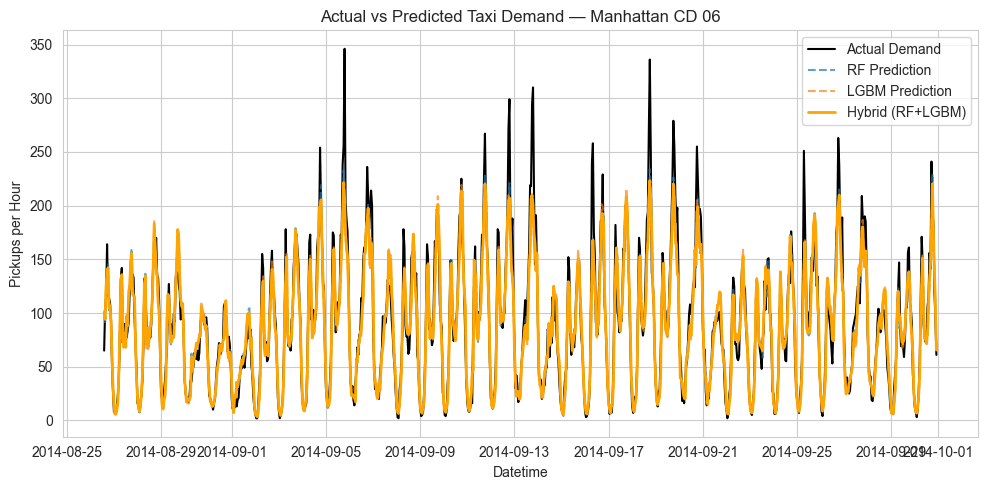

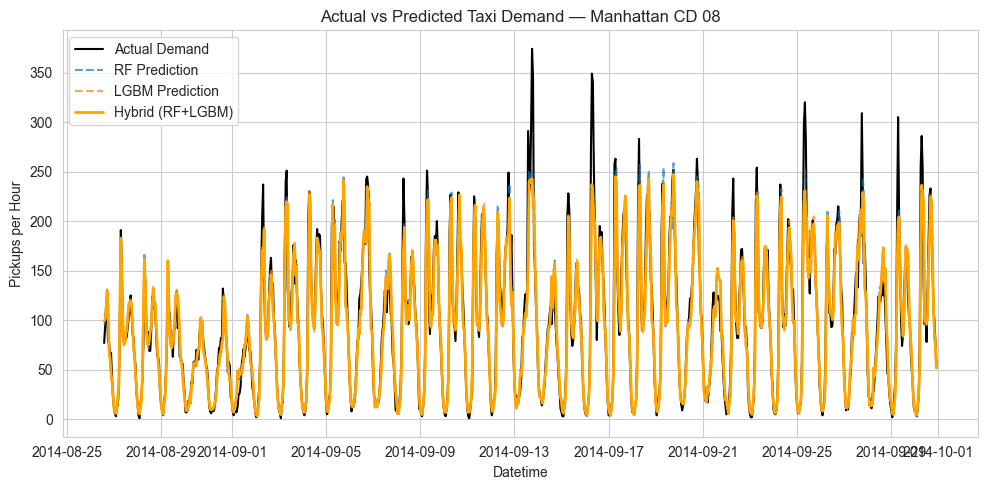

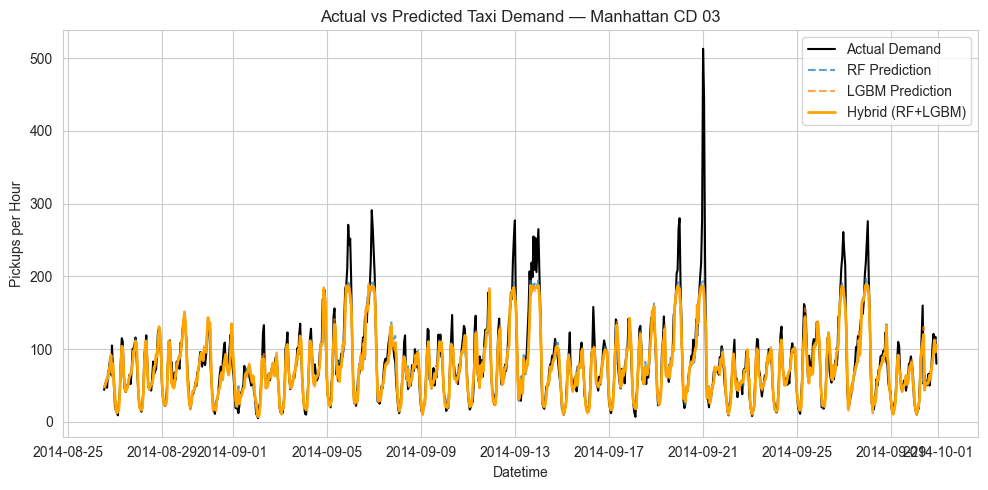

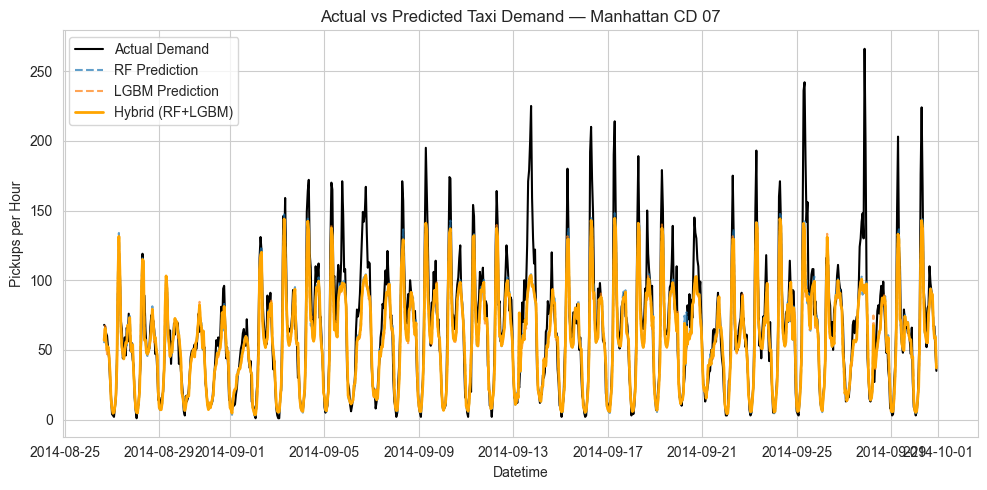

In [5]:
import matplotlib.pyplot as plt
import glob

# Path to the latest tree-based prediction folder
runs_dir = os.path.join(BASE_DIR, "data", "runs")
tree_runs = sorted([d for d in os.listdir(runs_dir) if d.startswith("tree_preds_")])
latest_tree_run = os.path.join(runs_dir, tree_runs[-1], "predictions")

print(f"📁 Loading predictions from: {latest_tree_run}")

# Select 2–3 example districts for visualization
example_districts = ["Manhattan CD 01", "Manhattan CD 05", "Brooklyn CD 01", "Manhattan CD 02", "Manhattan CD 04", "Manhattan CD 06", "Manhattan CD 08", "Manhattan CD 03", "Manhattan CD 07"]

for district in example_districts:
    slug = district.replace(" ", "_")
    pred_path = os.path.join(latest_tree_run, f"ensemble_preds_{slug}.csv")
    if not os.path.exists(pred_path):
        print(f"⚠️ Skipping {district} (no prediction file found)")
        continue

    df_pred = pd.read_csv(pred_path, parse_dates=["pickup_datetime"])
    plt.figure(figsize=(10, 5))
    plt.plot(df_pred["pickup_datetime"], df_pred["y_true"], label="Actual Demand", color="black", linewidth=1.5)
    plt.plot(df_pred["pickup_datetime"], df_pred["pred_rf"], label="RF Prediction", linestyle="--", alpha=0.7)
    plt.plot(df_pred["pickup_datetime"], df_pred["pred_lgbm"], label="LGBM Prediction", linestyle="--", alpha=0.7)
    plt.plot(df_pred["pickup_datetime"], df_pred["pred_ensemble"], label="Hybrid (RF+LGBM)", color="orange", linewidth=2)

    plt.title(f"Actual vs Predicted Taxi Demand — {district}")
    plt.xlabel("Datetime")
    plt.ylabel("Pickups per Hour")
    plt.legend()
    plt.tight_layout()
    plt.show()


The models effectively capture hourly periodicity and weekly repetition, crucial for optimizing taxi distribution.

Slight deviations appear during abrupt surges, but the ensemble maintains consistency and avoids overfitting noise. For operational use, this means reliable short-term forecasts, but potential gains if external data (e.g., profile of passengers, events or weather) were added.

## V. Identify best models per district

C:\Users\Monique\AppData\Local\Temp\ipykernel_5676\4261915528.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


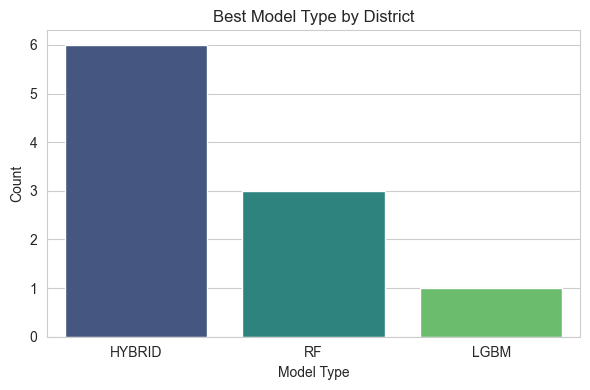

In [9]:
# Identify best models per district
eval_dir = os.path.join(BASE_DIR, "data", "evaluation")
summary_files = sorted([f for f in os.listdir(eval_dir) if f.startswith("all_models_eval_test")])

if not summary_files:
    raise FileNotFoundError("❌ No evaluation summary found")

eval_path = os.path.join(eval_dir, summary_files[-1])
df_eval = pd.read_csv(eval_path)

rmse_cols = [c for c in df_eval.columns if c.startswith("rmse_")]
df_eval["best_model"] = df_eval[rmse_cols].idxmin(axis=1)

best_counts = df_eval["best_model"].value_counts()

plt.figure(figsize=(6, 4))
sns.barplot(
    x=best_counts.index.str.replace("rmse_", "").str.upper(),
    y=best_counts.values,
    palette="viridis"
)
plt.title("Best Model Type by District")
plt.ylabel("Count")
plt.xlabel("Model Type")
plt.tight_layout()
plt.show()


## VI. Pipeline run log summary

,timestamp,step,duration_min,status,details
70,NaN,District modeling,0.43,success,run=tree_preds_20251113_154804
71,NaN,ConvLSTM training,4.93,success,"mean_rmse=30.96, mean_mae=21.02"
72,NaN,Training ConvLSTM models,5.14,success,NaN
73,NaN,Unified evaluation on test dataset,0.21,success,mean_rmse=42.664
74,NaN,Unified evaluation on test dataset,0.37,success,NaN
75,NaN,Generate next-hour map,NaN,success,C:\Users\Monique\Desktop\Model Engineering\tax...
76,NaN,Export forecast report,NaN,success,file=C:\Users\Monique\Desktop\Model Engineerin...
77,NaN,Generate next-hour map,NaN,success,C:\Users\Monique\Desktop\Model Engineering\tax...
78,NaN,Generate next-hour map,NaN,success,C:\Users\Monique\Desktop\Model Engineering\tax...
79,NaN,Generate next-hour map,NaN,success,C:\Users\Monique\Desktop\Model Engineering\tax...


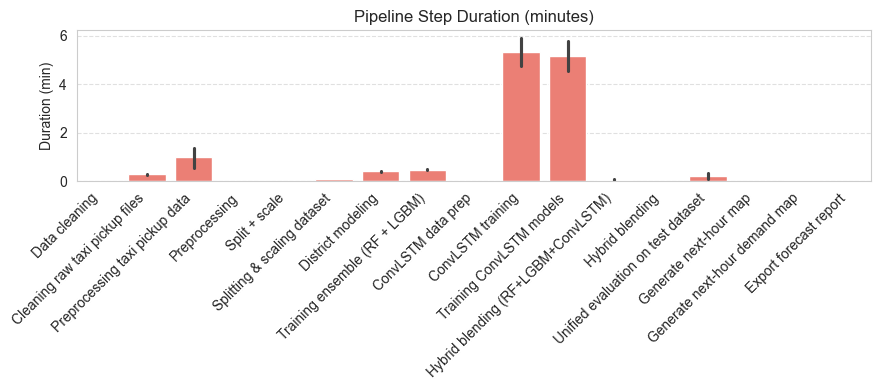

✅ Pipeline success rate: 87.5%


In [8]:
if os.path.exists(LOG_PATH):
    try:
        # Try normal fast read first
        log_df = pd.read_csv(LOG_PATH)
    except pd.errors.ParserError:
        # Fallback for inconsistent lines (old vs. new schema)
        log_df = pd.read_csv(LOG_PATH, on_bad_lines="skip", engine="python")
        print("⚠️ Some malformed log lines were skipped due to inconsistent columns.")

    # --- Standardize columns ---
    expected_cols = ["timestamp", "step", "duration_min", "status", "details"]
    for col in expected_cols:
        if col not in log_df.columns:
            log_df[col] = np.nan

    # --- Clean up ---
    log_df = log_df[expected_cols].drop_duplicates().reset_index(drop=True)
    log_df["duration_min"] = pd.to_numeric(log_df["duration_min"], errors="coerce")
    log_df = log_df.dropna(subset=["step"])

    display(HTML("<h4>📋 Recent Pipeline Runs</h4>"))
    display(log_df.tail(10))

    # --- Plot runtime chart ---
    plt.figure(figsize=(9, 4))
    sns.barplot(log_df, x="step", y="duration_min", color="#FF6F61")
    plt.xticks(rotation=45, ha="right")
    plt.title("Pipeline Step Duration (minutes)")
    plt.xlabel("")
    plt.ylabel("Duration (min)")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # --- Step success overview ---
    success_rate = (log_df["status"].str.contains("success", case=False, na=False).mean()) * 100
    print(f"✅ Pipeline success rate: {success_rate:.1f}%")
else:
    print("⚠️ No pipeline log found — please run the pipeline first.")


Training duration per pipeline run remains efficient (<1 minute for top districts), suitable for continuous daily or hourly updates.

## VII. Interactive map visualization

### Shows a next hour demand forecast and which model is used per district.

In [7]:
from IPython.display import IFrame, display

maps_dir = os.path.join(EVAL_DIR, "maps")
if os.path.exists(maps_dir):
    map_files = sorted(
        [f for f in os.listdir(maps_dir) if f.endswith(".html")],
        key=lambda x: os.path.getmtime(os.path.join(maps_dir, x))
    )
    latest_map = os.path.join(maps_dir, map_files[-1]) if map_files else None
else:
    latest_map = None

if latest_map:
    print(f"🗺️ Displaying saved map: {os.path.basename(latest_map)}")
    # ✅ Embed the HTML map inside the notebook
    display(IFrame(src=latest_map, width="100%", height="600"))

    print(f"📁 Full path: {latest_map}")
else:
    print("⚠️ No Folium map found in evaluation/maps.")


🗺️ Displaying saved map: next_hour_accuracy_map_20251113_162415.html


📁 Full path: C:\Users\Monique\Desktop\Model Engineering\taxidemand_forecast\data\evaluation\maps\next_hour_accuracy_map_20251113_162415.html


## VIII. Business Insights

The map provides a real-time, spatial view of predicted next-hour demand. Circle size reflects predicted pickup intensity; color represents the model type with the best performance per district. This forecast enables better fleet balancing and dispatch optimization.

Results show that hybrid (RF + LGBM + ConvLSTM blend) model is performing best in most districts. They mostly dominate in central Manhattan, where temporal patterns are complex and benefit from the deep model’s structure awareness.

RF win in Manhattan CD 04, 07 and CD 08, which are both business-heavy districts with more predictable demand cycles and less noise.

LGBM performs the strongest in Brooklyn CD 02 (RMSE ≈ 10.57), probably due to consisitent residential demand patterns.

The combination of ConvLSTM alone perfroms worse in comparison to other models where demand is irregular or sparse. The reason could be that the deep models overfit or underfit due to data scarcity. Manhattan CD 05 could benefit from a different model due to its higly volatile Midtown traffic.